<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/SampleDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Design (Microsoft Planet Computer) 
## This notebook demonstrates how to create a sample design that is spread and balanced in predictor variable space that can be used to build a machine learning model.
### Author: John Hogland 3/21/2023

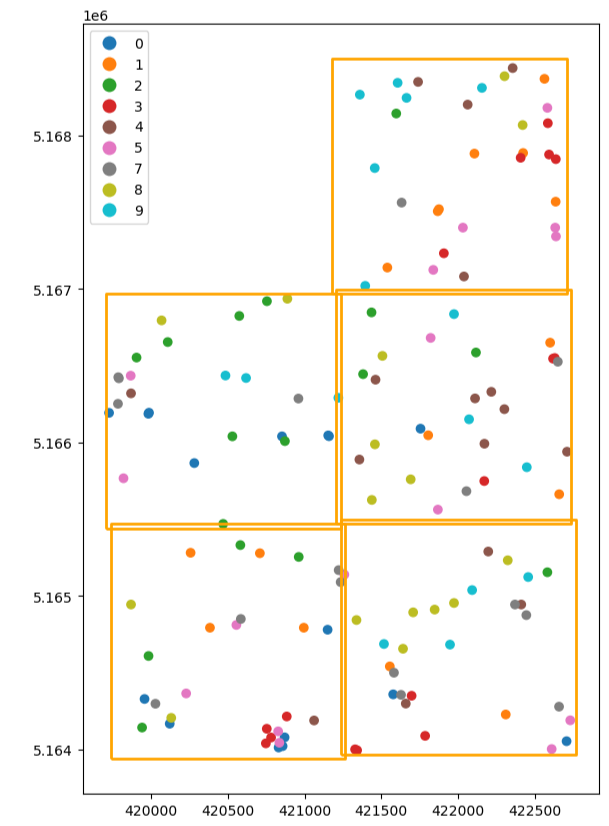

## Install packages

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install plotly
!pip install laspy[lazrs,laszip]
!pip install raster_tools
!pip install stackstac
!pip install planetary_computer
!pip install pystac_client
!pip install leafmap xarray_leaflet
!pip install localtileserver

## Get supporting python file

In [ ]:
import gdown, zipfile

url='https://drive.google.com/file/d/1dy7bnPKc4BPvHlH-PkrObXwb-SW9nv7n/view?usp=sharing'
outfl= r'./rs_las.py'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

## The Process
### In this notebook we will be using derivatives from Lidar data acquired from Microsoft's Planetary Computer to spread and balance a samples across predictor variable space. This notebooks builds upon the Lidar [Download](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarDownload.ipynb) and [Processing](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarProcessing.ipynb) notebooks at [Spatial Modeling Tutorials](https://github.com/jshogland/SpatialModelingTutorials).  


### Steps
1. Import python libraries and download laz files
2. Create Point Cloud raster surface predictors 
3. Visualize predictor surfaces
4. Create a large random sample and extract predictor values
5. Create a stratified random sample of 150 locations that are well spread
6. Collect field data for those locations

## Step 1: Import libraries and get data
### Import libary

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import rs_las

import planetary_computer
import pystac_client
import requests
import stackstac

from dask.diagnostics import ProgressBar


from raster_tools import Raster
from raster_tools import zonal

from shapely.geometry import shape
from shapely.ops import transform

import leafmap.leafmap as leafmap



## *If you already have the laz files for Helena from the [Lidar Download](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarDownload.ipynb) notebook, you can skip to Step 2*
### Set the point location to Helena MT

In [ ]:
loc = {"type": "Point", "coordinates": [-112.027, 46.64]} # just a little north of town
geom = shape(loc) # create a shapely point
geom_buff=geom.buffer(0.01) #buffer area to create a area of interest (AOI)

### Get the laz data from Planetary Computer
#### We will be using laz files downloaded from Planetary Computer for a small area around Helena MT. To download the laz files run the following cell or work through the [LidarDownload.ipynb](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarDownload.ipynb) notebook.

In [ ]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

search = catalog.search(collections=["3dep-lidar-copc"], intersects=geom_buff)
ic = search.get_all_items()

#create a output folder if it does not already exist

output_folder= './lidar_cloud'
if(not os.path.exists(output_folder)): os.mkdir(output_folder)

for tile in ic:
        url = tile.assets["data"].href
        nm = tile.id + '.copc.laz'
        print('downloading ' + nm)
        r=requests.get(url,allow_redirects=True)
        open(output_folder+'/'+nm,'wb').write(r.content)

## *If you have already saved predictor surfaces for Helena from the [Lidar Processing notebook](https://github.com/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarProcessing.ipynb), you can skip to Step 3*
## Step 2: Create Laz Predictors Surfaces (Raster objects 30m)

- zmean
- zmax
- zp10, zp25, zp50, zp75, zp90, zp99
- zfcc
- zfsc
- zcv

### Use [rs_las](./rs_las.py) to create the metrics (aggtypes) and save to a conventional raster type

In [ ]:
%%time
laz_dir = './lidar_cloud'
laz_files_lst=[]
for f in os.listdir(laz_dir):
    if f[-4:]=='.laz': laz_files_lst.append(laz_dir+"/"+f)

res=30

gdf=rs_las.build_extents(laz_files_lst)

aggtypes=['mean','max','quantile:0.1,0.25,0.5,0.75,0.9,0.99','zfcc','zfsc','zcv']
rs_z=rs_las.get_raster(gdf,res,aggtypes)
rs_z.save('Lidar_30_metrics.tif')

## Step 3: Visualize predictor surfaces using [Leafmap](https://leafmap.org/leafmap/)

In [ ]:
#Specify the name of the predictor raster stack
outname='Lidar_30_metrics.tif'

#Create a leafmap map object
m = leafmap.Map()

#Add ESRI's World imagery as a tile layer
m.add_tile_layer(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', name = 'Esri Imagery',attribution='ESRI')

#Add each band of the raster to the map object
m.add_raster(outname,bands=[11], layer_name='Coefficent of Variation (z)')
m.add_raster(outname,bands=[10], layer_name='% Shrub Cover')
m.add_raster(outname,bands=[9], layer_name='% Canopy Cover')
m.add_raster(outname,bands=[8], layer_name='99% (z)')
m.add_raster(outname,bands=[7], layer_name='90% (z)')
m.add_raster(outname,bands=[6], layer_name='75% (z)')
m.add_raster(outname,bands=[5], layer_name='50% (z)')
m.add_raster(outname,bands=[4], layer_name='25% (z)')
m.add_raster(outname,bands=[3], layer_name='10% (z)')
m.add_raster(outname,bands=[2], layer_name='max (z)')
m.add_raster(outname,bands=[1], layer_name='mean (z)')

#show the map
m

## Step 4: Create large random sample 
- create a large random sample of spatial locations (~100 times the sample size)
- extract the predictor surface values for each location and populate point values
- we will use this sample to select a well spread and balanced sample using kmean clustering

In [ ]:
#create large random sample
bn=150*100
predictors84=Raster(outname)
laz_dir = './lidar_cloud'
laz_files_lst=[]
for f in os.listdir(laz_dir):
    if f[-4:]=='.laz': laz_files_lst.append(laz_dir+"/"+f)

gdf=rs_las.build_extents(laz_files_lst)


bnds=gdf.total_bounds

pred=Raster(predictors84.xdata.rio.reproject(gdf.crs))

x=np.random.randint(bnds[0],bnds[2],bn)
y=np.random.randint(bnds[1],bnds[3],bn)
b_loc=gpd.GeoDataFrame(geometry=gpd.points_from_xy(x,y,crs=gdf.crs))
b_loc2=b_loc[b_loc.intersects(gdf.unary_union)]

p1=gdf.plot(facecolor="none",edgecolor='orange',figsize=(15,15),linewidth=2,zorder=1)
p2=b_loc2.plot(ax=p1,color='blue',zorder=0)
p2

In [ ]:
#extract predictor surface values
pvls=zonal.extract_points_eager(b_loc2,pred,'Lidar').compute()

#create common index for pvls and locations
pvls['pltid']=list(b_loc2.index.values)*11
pvls['band']=pvls['band'].astype(str)
b_loc2['pltid']=b_loc2.index.values

#transpose pvls, fill NaN values, and merge location with surface values and visualize
b_sample=b_loc2.merge(pvls.pivot(index='pltid',columns='band',values='Lidar').fillna(0),on='pltid')
b_sample

## Step 5: Create a stratified random sample of ~150 locations that is well spread.
### We are sampling locations because it is too expensive to completely inventory a natural resource (e.g., Tree Basal Area). From the sample we can make estimates about the population, i.e. the study area (design based inference). However, we can also use this sample to train a model that can be used to gain insights to smaller spatial domains (the cell). Using our sample we will create a model that can be used to predict estimates using the inventory of Lidar data based metrics ([LidarEstimatingBaa.ipynb]()) and use those estimates to infer population statistics (model based inference). To build a stratified random sample we will be using information from our Lidar based surfaces. 
- we will subset our large random sample to create a well spread sample
- we will be using sklearn's k-means algorithm to create 10 clusters
- from each cluster we will select ~15 random locations
- finally let's visualize the spatial location of each field observation

In [ ]:
from sklearn.cluster import KMeans
c=10
n=15
X = b_sample[['1','2','3','4','5','6','7','8','9','10','11']]
mdl=KMeans(n_clusters=10).fit(X)
b_sample['cluster']=(mdl.fit_predict(X)).astype('str')
test=np.unique(b_sample.cluster,return_counts=True)
n=int(c/np.sum(test[1]>=n) * n)

def samp_c(x,size):
    if(x.shape[0]>size):return x.sample(size)

wsb_sample=b_sample.groupby('cluster', group_keys=False).apply(lambda x: samp_c(x,n)) 
print("The total sample size = " + str(wsb_sample.shape[0]))

p1=gdf.plot(facecolor="none",edgecolor='orange',figsize=(10,10),linewidth=2,zorder=1)
p2=wsb_sample.plot(ax=p1,column='cluster',legend=True,zorder=0)
p2

## Step 6: Collect field data
- unfortunately we can't go to the field in this exercise
- instead, we will create a relationship between our Lidar metrics and basal area as a surrogate for actual field data collection
- our measurement we will be "collecting" for each location (field plot) is total tree basal area per acre (BAA) measured in ft<sup>2</sup> per acre
- the equation to calculate our wsb_sample is $ BAA = 20 + 2*zcv + 1.5*zfcc + 0.9*zfsc + 0.53*zp90 + random()*10) $
- save the dataframe as a shape file

In [ ]:
#create BAA and visualize
wsb_sample['BAA']=20 + (2*wsb_sample['11']) + (1.5*wsb_sample['9']) + (0.9*wsb_sample['10']) + (0.530*wsb_sample['7']) + (np.random.random(wsb_sample.shape[0])*10)
wsb_sample['BAA'].plot.hist()

In [ ]:
#save the dataframe
wsb_sample.to_file('train.shp')

# This ends the Sample Design notebook
## Check out the other notebooks:
- https://github.com/jshogland/SpatialModelingTutorials/tree/main/Notebooks
## References
- Spatial Modeling Notebooks:  https://github.com/jshogland/SpatialModelingTutorials
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html